In [1]:
import numpy as np
import pandas as pd

from utils import *
from constants import *
from models import *

2024-04-21 11:00:24.518971: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-21 11:00:24.520461: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-21 11:00:24.538800: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-21 11:00:24.538814: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-21 11:00:24.539365: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

## Display Results

## Display Results

In [2]:
results = pd.read_csv('results.csv')

# Print results
for idx, row in results.iterrows():
    print("Model:", row['Model Name'])
    for metric, value in row.items():
        if metric != 'Model Name':
            print(f"{metric:50} {value if isinstance(value, str) else round(value, 2)}")
    print("\n")

Model: Non-probabilistic MLP
Train RMSE                                         27.27
Train MAE                                          16.32
Test RMSE                                          27.85
Test MAE                                           16.59
Test % within 95.00% CI                            96.24
Test % within 99.00% CI                            93.21


Model: Epistemic Uncertainty BNN (Flipout) - 1.0% Sample
Train RMSE                                         124.99
Train MAE                                          92.54
Test RMSE                                          124.93
Test MAE                                           92.37
Test % within 95.00% CI                            17.17
Test % within 99.00% CI                            13.27


Model: Epistemic Uncertainty BNN (Flipout)
Train RMSE                                         29.38
Train MAE                                          18.11
Test RMSE                                          29.75
Test MAE  

In [3]:
# Format results to be added to a latex table.

results = pd.read_csv('results.csv')

metrics = results.columns[1:]

for idx, row in results.iterrows():
    formatted_line = ""
    for i, metric in enumerate(metrics):
        value = row[metric]
        # Try converting string values to floats
        try:
            value = float(value)
        except ValueError:
            pass 
        # Format the value to two decimal places
        formatted_value = "{:.2f}".format(value) if isinstance(value, float) else value
        if i == len(metrics) - 1:
            formatted_value += "\%" 
        
        formatted_line += f" & {formatted_value}"
        if i == 0:
            formatted_line = str(row['Model Name']) + " " + formatted_value
    print(formatted_line + " \\\\")
    print("\n")

Non-probabilistic MLP 27.27 & 16.32 & 27.85 & 16.59 & 96.24 & 93.21\% \\


Epistemic Uncertainty BNN (Flipout) - 1.0% Sample 124.99 & 92.54 & 124.93 & 92.37 & 17.17 & 13.27\% \\


Epistemic Uncertainty BNN (Flipout) 29.38 & 18.11 & 29.75 & 18.28 & 25.64 & 19.66\% \\


Probabilistic MLP (Separate Sub-models) 28.28 & 15.16 & 29.10 & 15.42 & 98.22 & 94.01\% \\


Prob. MLP (Fine-tuned) 24.86 & 13.43 & 25.57 & 13.80 & 98.53 & 95.11\% \\


Stochastic Output BNN (Flipout) 29.64 & 16.27 & 30.06 & 16.47 & 98.38 & 94.50\% \\


Prob. MLP 27.14 & 14.47 & 28.19 & 14.99 & 98.37 & 94.37\% \\


Probabilistic CNN with Gaussian Output 32.40 & 18.51 & 33.38 & 18.95 & 97.35 & 91.28\% \\


Probabilistic Multivariate MLP (Only Diagonal, separate branches) 38.03 & 24.20 & 42.06 & 26.91 & 97.78 & 92.77\% \\


Probabilistic Multivariate MLP (Only Diagonal) 41.47 & 26.83 & 44.26 & 28.96 & 97.26 & 91.70\% \\


Probabilistic Multivariate MLP (Lower Triangular Covariance Matrix) 53.46 & 34.23 & 56.50 & 36.53 & 99.

## Additional Plots

In [4]:
df_train = pd.read_pickle(open(DATA_PATH + '/cleaned/train.pkl','rb'))
df_test = pd.read_pickle(open(DATA_PATH + '/cleaned/test.pkl','rb'))

In [5]:
print("Full Training Set Size: ", df_train.shape[0])
print("Full Testing Set Size: ", df_test.shape[0])

df_train_single = df_train[df_train['turbine'] == TURBINE_ID]
df_test_single = df_test[df_test['turbine'] == TURBINE_ID]
df_train_single.reset_index(drop=True, inplace=True)
print("Turbine#{TURBINE_ID} Training Set Size: ", df_train.shape[0])
print("Turbine#{TURBINE_ID} Testing Set Size: ", df_test.shape[0])
df = pd.concat([df_train_single, df_test_single])

Full Training Set Size:  807764
Full Testing Set Size:  201943
Turbine#{TURBINE_ID} Training Set Size:  807764
Turbine#{TURBINE_ID} Testing Set Size:  201943


In [6]:
X_train, X_test, \
    y_train, y_test, \
    scaler = create_design_matrix(df_train_single, df_test_single, FEATURES, OUTPUT_FEATURE)

In [7]:
df_preds = pd.read_csv('preds.csv')

bnn_pred = np.array(df_preds.loc[df_preds['Model Name'] == 'Stochastic Output BNN (Flipout)', 'y_test_pred'].tolist())
bnn_stddevs = np.array(df_preds.loc[df_preds['Model Name'] == 'Stochastic Output BNN (Flipout)', 'y_test_stddevs'].tolist())
mlp_pred = np.array(df_preds.loc[df_preds['Model Name'] == 'Prob. MLP', 'y_test_pred'].tolist())
mlp_stddevs = np.array(df_preds.loc[df_preds['Model Name'] == 'Prob. MLP', 'y_test_stddevs'].tolist())
gp_pred = np.array(df_preds.loc[df_preds['Model Name'] == 'GP (RBF, sparse)', 'y_test_pred'].tolist())
gp_stddevs = np.array(df_preds.loc[df_preds['Model Name'] == 'GP (RBF, sparse)', 'y_test_stddevs'].tolist())
mlp_ft_pred = np.array(df_preds.loc[df_preds['Model Name'] == 'Prob. MLP (Fine-tuned)', 'y_test_pred'].tolist())
mlp_ft_stddevs = np.array(df_preds.loc[df_preds['Model Name'] == 'Prob. MLP (Fine-tuned)', 'y_test_stddevs'].tolist())
lmlp_pred = np.array(df_preds.loc[df_preds['Model Name'] == 'Large Prob. MLP', 'y_test_pred'].tolist())
lmlp_stddevs = np.array(df_preds.loc[df_preds['Model Name'] == 'Large Prob. MLP', 'y_test_stddevs'].tolist())
lmlp_ft_pred = np.array(df_preds.loc[df_preds['Model Name'] == 'Large Prob. MLP (Fine-tuned)', 'y_test_pred'].tolist())
lmlp_ft_stddevs = np.array(df_preds.loc[df_preds['Model Name'] == 'Large Prob. MLP (Fine-tuned)', 'y_test_stddevs'].tolist())

y_test_pred_list = [gp_pred,
                    bnn_pred,
                    mlp_pred,
                    mlp_ft_pred,
                    lmlp_pred,
                    lmlp_ft_pred]

y_test_std_list = [gp_stddevs,
                    bnn_stddevs,
                    mlp_stddevs,
                    mlp_ft_stddevs,
                    lmlp_stddevs,
                    lmlp_ft_stddevs]

y_test_list = [y_test,
                y_test,
                y_test,
                y_test,
                y_test,
                y_test]

titles = ["Sparse GP",
            "BNN",
            "PMLP with architecture A1",
            "LPMLP with architecture A1",
            "PMLP with architecture A2",
            "LPMLP with architecture A2 "]

Sparse GP, MCE: 17.789687673258186
BNN, MCE: 1.6684267497425935
PMLP with architecture A1, MCE: 1.119676848747261
LPMLP with architecture A1, MCE: 1.8743564696253685
PMLP with architecture A2, MCE: 1.0432452411753843
LPMLP with architecture A2 , MCE: 1.7723156532988327


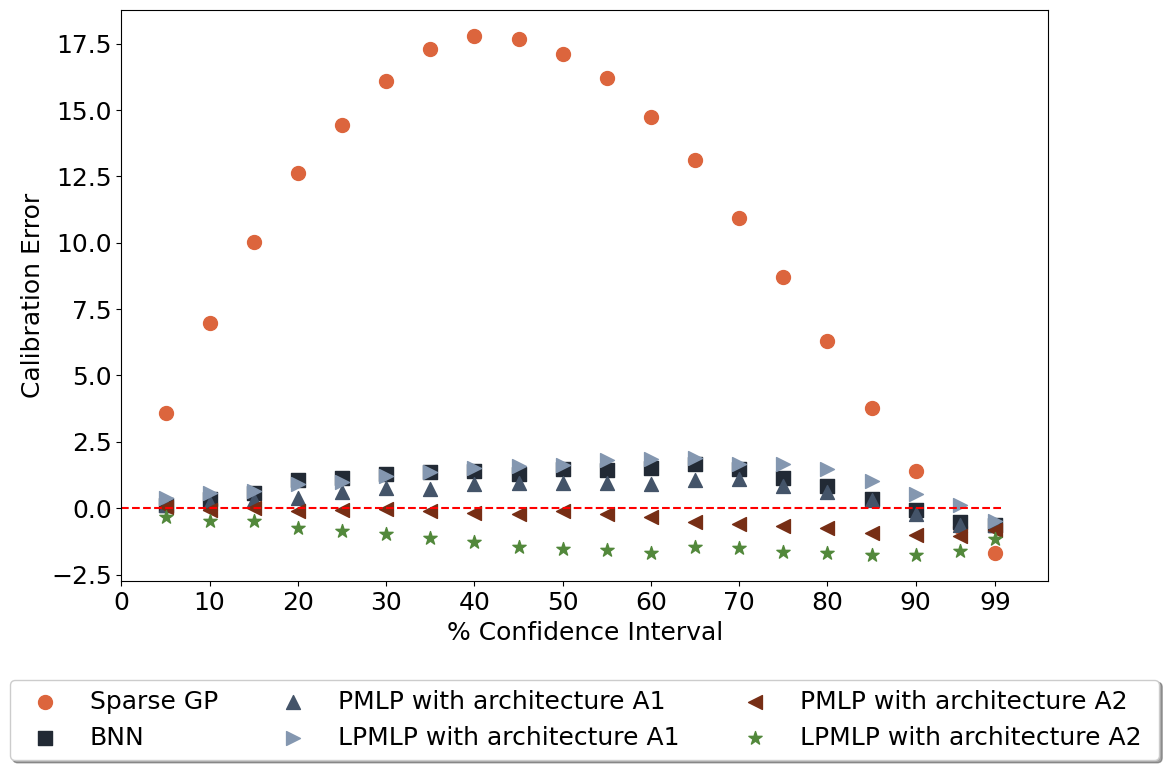

In [8]:
plot_calibration_errors(y_test_pred_list, y_test_std_list, y_test_list, bins=20, with_legend=True, titles=titles) 

## Interactive QQ plot

In [9]:
if COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    DATA_PATH = "/content/drive/My Drive/Colab Notebooks/FYP/UK Wind Turbines"

df = pd.read_pickle(open(DATA_PATH + '/cleaned/full.pkl','rb'))

In [10]:
df = df[df['turbine'] == TURBINE_ID]
df = df.dropna(subset=FEATURES + [OUTPUT_FEATURE] + [DATETIME_COL])
df.reset_index(drop=True, inplace=True)


In [11]:
X_live, y_live = get_live_data(df, start_index=-144)

In [12]:
model = create_model_mlp_gaussian_large(X_live, 42)
model.summary()

model.load_weights('saved_models/mlp_large_finetuned.keras')
evaluation = model.evaluate(X_live, y_live)
print("Evaluation Loss:", evaluation)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 34)]              0         
                                                                 
 dense (Dense)               (None, 300)               10500     
                                                                 
 dense_1 (Dense)             (None, 200)               60200     
                                                                 
 dense_2 (Dense)             (None, 100)               20100     
                                                                 
 dense_3 (Dense)             (None, 2)                 202       
                                                                 
 distribution_lambda (Distr  ((None, 1),               0         
 ibutionLambda)               (None, 1))                         
                                                             

2024-04-21 11:00:29.437246: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-21 11:00:29.437448: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


5919/5919 [==============================] - 2s 369us/step - loss: 164167.6406
Evaluation Loss: 164167.640625


In [13]:
y_live_pred = np.array(model(X_live).mean()).ravel()
y_live_stddevs = np.array(model(X_live).stddev()).ravel()

evaluate_and_save_metrics(None,
    y_live, y_live, y_live_pred, y_live_pred,
    y_live_stddevs, y_live_stddevs, 0.99)

Train RMSE: 22.392
Test RMSE: 22.392
Train MAE: 11.992
Test MAE: 11.992
Percentage of Test Data Points within 99.00% CI: 98.56%
Percentage of Test Data Points within 99.00% CI: 98.56%
Percentage of Test Data Points within 95.00% CI: 94.76%
Percentage of Test Data Points within 95.00% CI: 94.76%


In [14]:
t = 2850
dates = df.loc[t:t+143, DATETIME_COL]
X_live, y_live = get_live_data(df, t, t+143)
normalized_residuals = calculate_normalized_residuals(model, X_live, y_live)

In [15]:
# qq_plot(normalized_residuals, 0.99)
interactive_qq_plot(df, model)

interactive(children=(IntText(value=230, description='Start Index:'), IntText(value=374, description='End Inde…

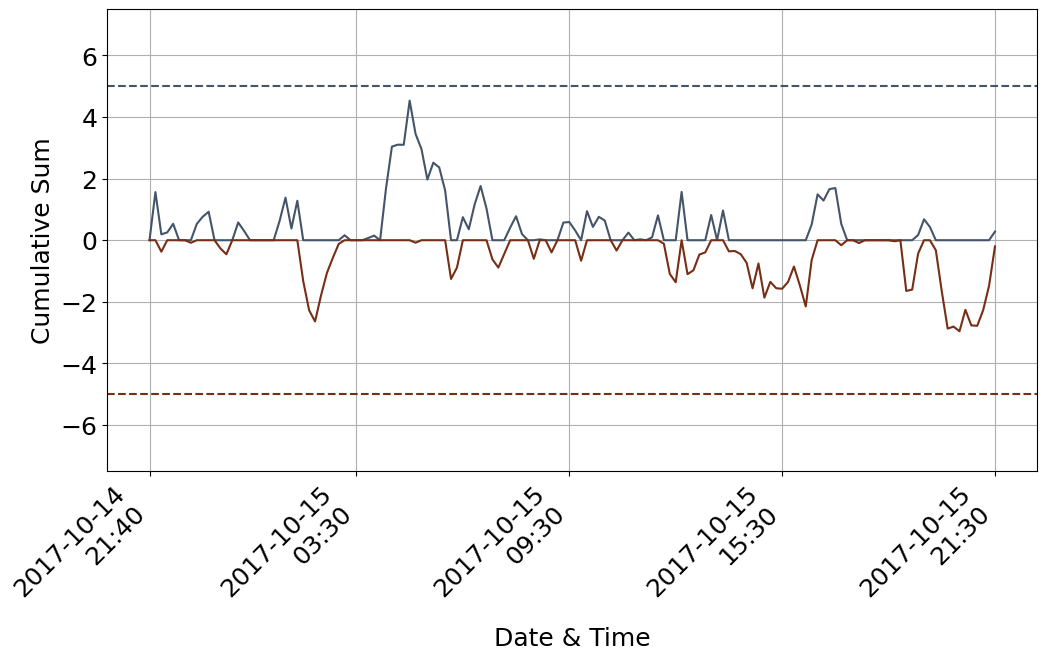

In [16]:
cusum_test_plot(normalized_residuals, pd.to_datetime(dates))

In [17]:
df = pd.read_pickle(DATA_PATH + '/unfiltered/full.pkl')
df = df[df['turbine'] == TURBINE_ID]

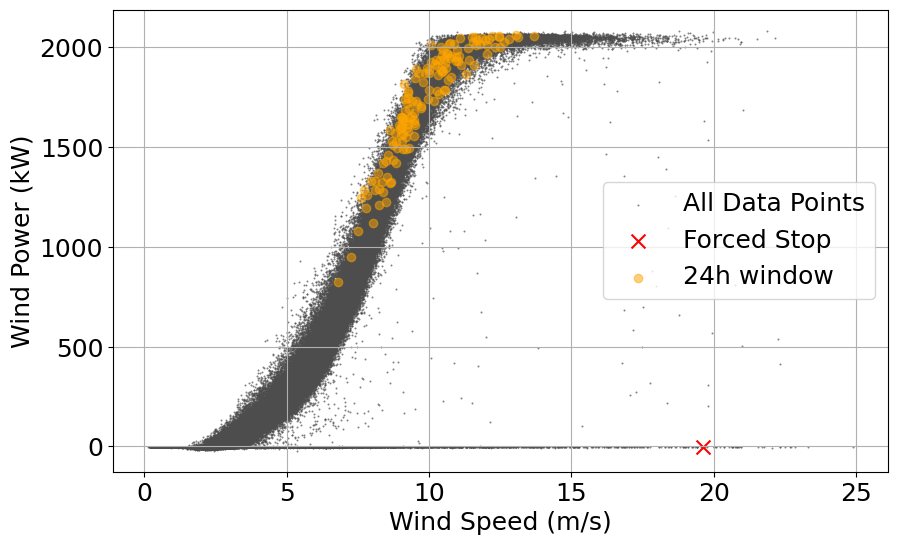

In [18]:
fault_date = pd.Timestamp('2018-01-18 04:22:23') # Where the fault is
reference_date = pd.Timestamp('2018-01-17 10:30:01') # Illustrative to show the fault is detected early
mask_fault = (pd.to_datetime(df[DATETIME_COL]) > fault_date) \
        & (pd.to_datetime(df[DATETIME_COL]) < fault_date + pd.Timedelta(minutes=10))

mask_period = (pd.to_datetime(df[DATETIME_COL]) > reference_date - pd.Timedelta(minutes=10*143)) \
        & (pd.to_datetime(df[DATETIME_COL]) < reference_date - pd.Timedelta(minutes=10))
unhealthy_indices = detect_visible_faults(df, mask_fault, mask_period, save_path="plots/fault.pdf")

In [19]:
df_unhealthy = df.loc[unhealthy_indices.index]
df_unhealthy.dropna(subset=FEATURES + [OUTPUT_FEATURE], inplace=True)
display(df_unhealthy)

,Date.time,Power.me,Power.sd,Power.min,Power.max,Pot.Power.me,Wind.speed.me,Wind.speed.sd,Wind.speed.min,Wind.speed.max,...,Blade.ang.pitch.pos.C.sd,Blade.ang.pitch.pos.C.min,Blade.ang.pitch.pos.C.max,Gear.oil.inlet.press.me,Gear.oil.pump.press.me,Drive.train.acceleration.me,Tower.Acceleration.x,Tower.Acceleration.y,turbine,year
1262657,2018-01-16 10:50:00,1909.519165,266.490570,1067.984253,2119.685547,1853.582153,10.285767,1.399522,7.726889,13.115211,...,NaN,NaN,NaN,226.893265,795.190979,156.583923,70.482315,52.208694,5,2018
1262658,2018-01-16 11:00:00,1531.671265,339.942139,906.857117,2068.765137,1251.293430,8.687610,1.190002,6.108610,11.745298,...,NaN,NaN,NaN,228.085449,799.009094,164.654846,84.512482,43.793907,5,2018
1262659,2018-01-16 11:10:00,1493.141602,407.602753,848.232422,2088.196289,1460.726662,9.204111,1.512391,6.749016,12.210104,...,NaN,NaN,NaN,230.041809,802.393860,143.233276,80.764374,36.559395,5,2018
1262660,2018-01-16 11:20:00,1765.530762,373.574249,1006.307800,2103.306152,1865.873246,10.345723,1.634526,6.508446,13.134888,...,NaN,NaN,NaN,232.212860,804.139648,143.044678,77.111473,53.886345,5,2018
1262661,2018-01-16 11:30:00,1629.931152,376.086273,882.474609,2097.789307,1442.771912,9.161362,2.270015,5.262903,15.419560,...,NaN,NaN,NaN,234.190735,807.364014,160.123474,95.147873,50.728996,5,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1262794,2018-01-17 09:40:00,1887.560547,246.013077,1206.329468,2116.078857,1880.839605,10.418730,1.537820,6.493225,13.075487,...,NaN,NaN,NaN,233.718170,812.023682,199.280869,128.534912,56.967518,5,2018
1262795,2018-01-17 09:50:00,1966.007080,149.531677,1566.507324,2123.889893,1923.204179,10.625386,1.462721,8.072894,14.019205,...,NaN,NaN,NaN,236.972763,812.945618,221.699783,121.263382,90.984489,5,2018
1262796,2018-01-17 10:00:00,1973.789185,152.976486,1549.306152,2144.185303,1923.664589,10.627632,1.919650,6.680706,13.927506,...,NaN,NaN,NaN,242.623337,818.533447,233.444901,119.074821,67.491516,5,2018
1262797,2018-01-17 10:10:00,2000.796631,113.905174,1784.455811,2127.571289,2043.098030,12.309803,1.785712,8.483497,15.473763,...,NaN,NaN,NaN,230.348663,801.587891,232.297302,100.934349,91.240997,5,2018


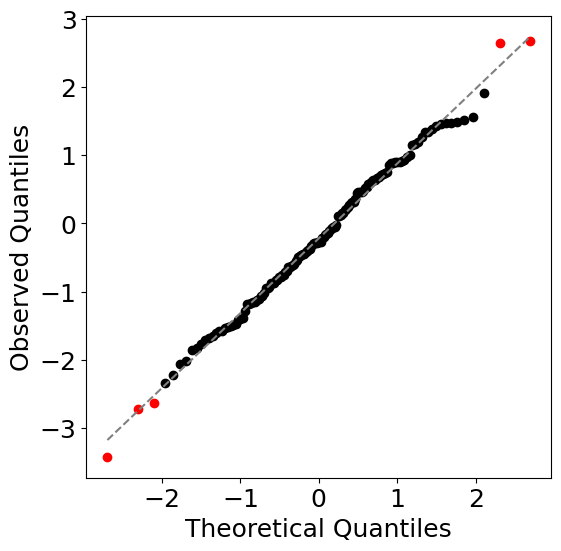

In [20]:
X_unhealthy, y_unhealthy = get_live_data(df_unhealthy, 0)
normalized_residuals = calculate_normalized_residuals(model, X_unhealthy, y_unhealthy)

qq_plot(normalized_residuals ,0.99)

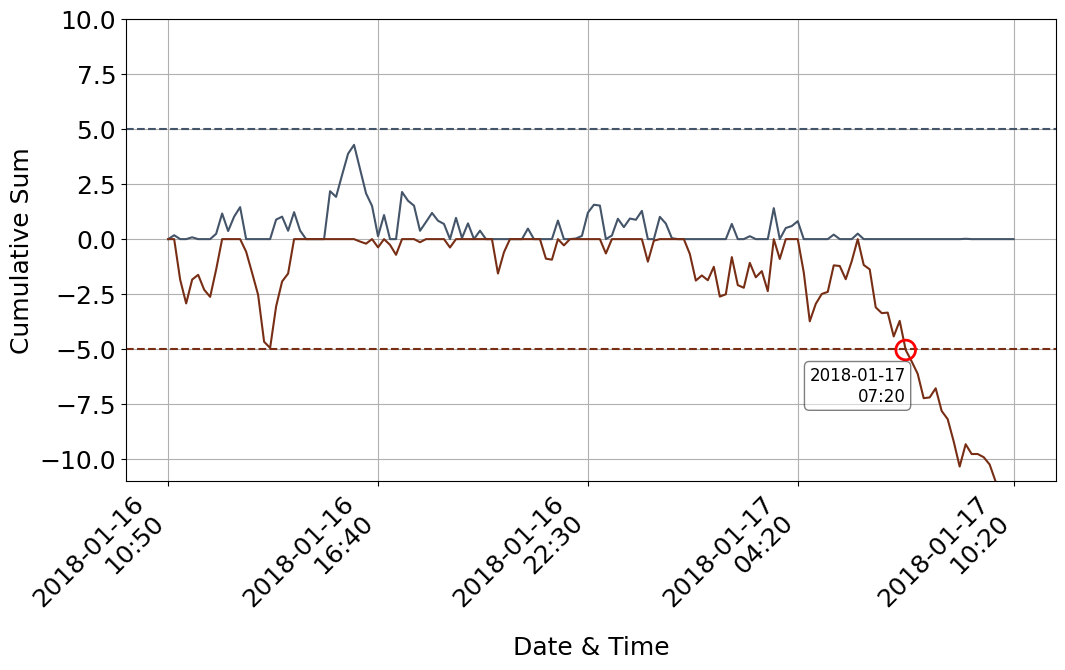

In [21]:
cusum_test_plot(normalized_residuals, pd.to_datetime(df_unhealthy[DATETIME_COL]))